### CASA0002

# Urban Simulation
***

![img](https://tfl.gov.uk/cdn/static/cms/images/london-rail-and-tube-services-map.gif)

In [1]:
# we will import all the necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

In [2]:
# read csv file
london_flows = pd.read_csv("london_flows.csv")
london_flows.head(5)
# london_flows.shape (61474, 6)

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# read GraphML
G = nx.read_graphml('London_G.graph')

In [4]:
df_test = nx.to_pandas_edgelist(G)
df_test = df_test.sort_values(by="flows")
df_test.head(5)

,source,target,length,flows,line_name
398,Kennington,Nine Elms,2030.621843,0,Northern
426,Battersea Power Station,Nine Elms,1073.465362,0,Northern
224,Wandsworth Road,Battersea Park,1168.489261,0,London Overground
396,Elephant & Castle,Lambeth North,995.720282,94,Bakerloo
153,Theobalds Grove,Cheshunt,1539.905628,287,London Overground


# Part1 I. Topological network

In this part, you will evaluate the resilience of the London’s underground through the removal of stations that can potentially make the underground vulnerable. Through the procedure outlined below you will investigate which are the stations that are most critical for the functioning of the underground, and which methodology is more appropriate to finding these stations.

## Part I.1 Centrality measures:

Select 3 centrality measures to characterise nodes, aiming at identifying the most important nodes in the underground network. Give the definition of each of the measures (including their equation), put the measures into the context of the underground, and why they will allow you to find the stations that are most crucial for the functioning of the underground. Compute the measures for your nodes in the network, and give the results in a table for the first 10 ranked nodes for each of the 3 measures.

### Preparation

In [5]:
# list all operations of the G object
print(len(dir(G)))
for i in np.random.randint(0, len(dir(G)), 10):
    print(dir(G)[i])

77
add_edges_from
has_edge
__reduce__
graph_attr_dict_factory
subgraph
get_edge_data
add_edges_from
add_nodes_from
has_edge
__iter__


In [6]:
print(G.number_of_nodes())
print(G.number_of_edges())

401
467


In [7]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

In [8]:
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [9]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)})

In [10]:
# To check edges attributes:
list(G.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356})

In [11]:
# Iterate over each node in the graph and its attributes
for node, data in G.nodes(data=True):
    # Add the 'station_name' key to the node attribute
    data['station_name'] = node

# Check - it has been added correctly 
print(list(G.nodes(data=True))[0])

('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672), 'station_name': 'Wembley Park'})


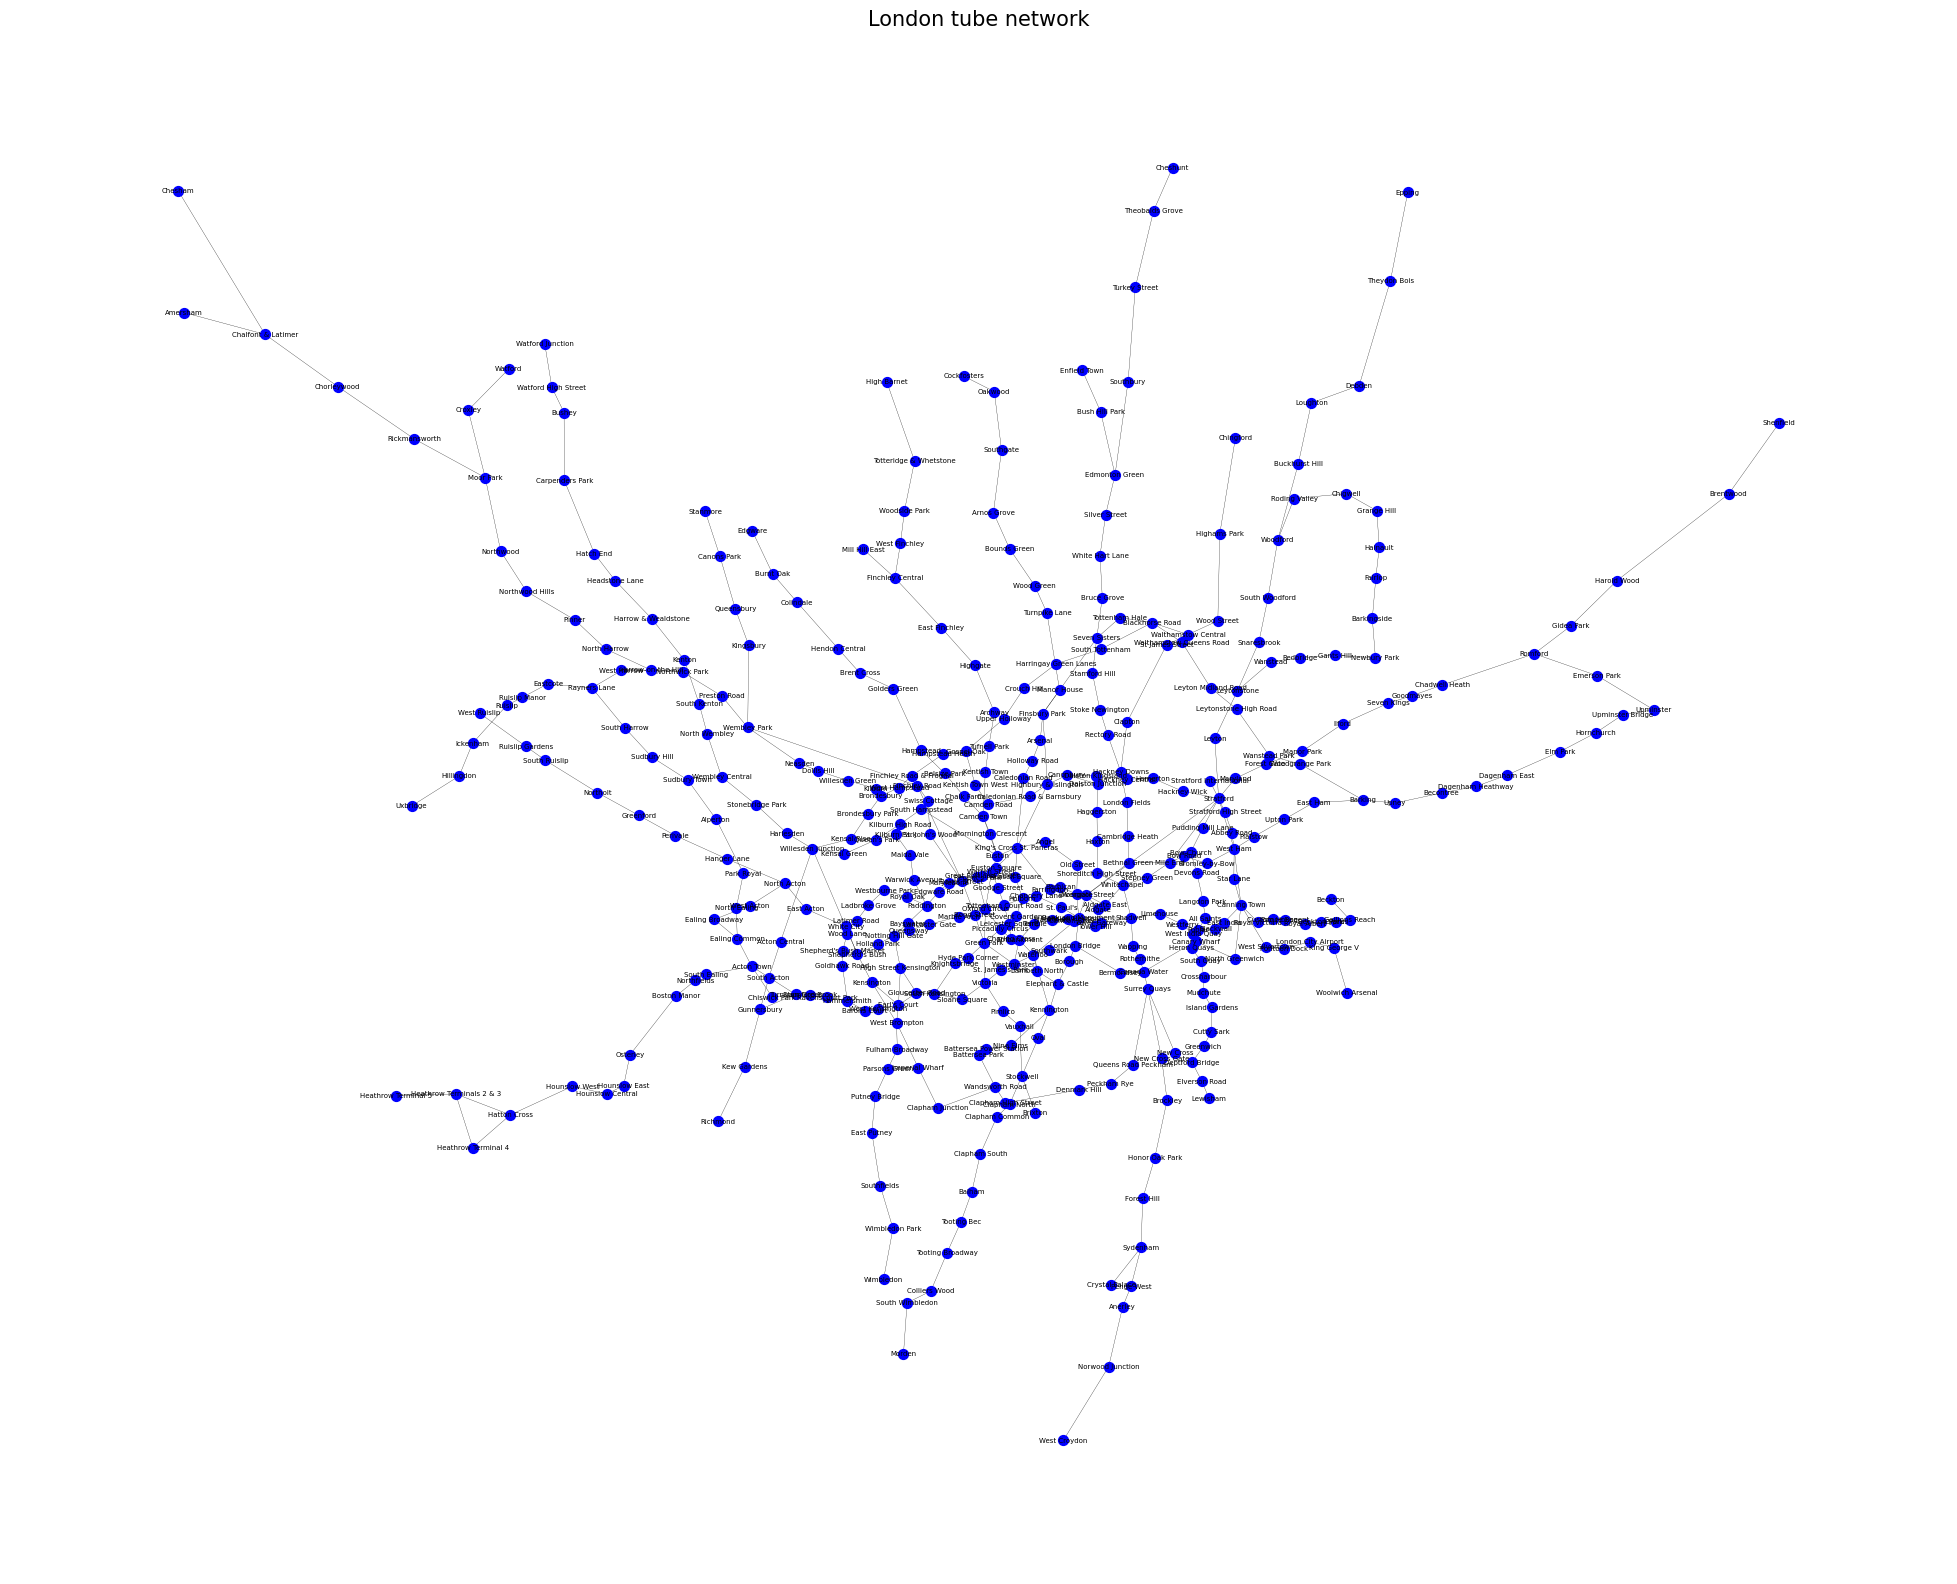

In [12]:
### Let's plot the tube network! 

# We can plot the tube network with the names of the stations as labels
fig, ax = plt.subplots(figsize=(25,20))

node_labels = nx.get_node_attributes(G, 'station_name')

pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G,pos,node_size=50,node_color='blue')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G,pos, node_labels, font_size=5, font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()

In [13]:
#We can print the dataframe from the shapefile to check the data
df_G = nx.to_pandas_edgelist(G)
df_G[0:10]

,source,target,length,flows,line_name
0,Wembley Park,Kingsbury,2916.771558,12356,Jubilee
1,Wembley Park,Neasden,2353.165938,6744,Jubilee
2,Wembley Park,Preston Road,1419.735166,36601,Metropolitan
3,Wembley Park,Finchley Road,7266.373927,55216,Metropolitan
4,Kingsbury,Queensbury,1245.995234,9419,Jubilee
5,Queensbury,Canons Park,1693.307343,6385,Jubilee
6,Canons Park,Stanmore,1419.669476,3624,Jubilee
7,Stratford,West Ham,1673.509515,91801,Jubilee
8,Stratford,Mile End,2805.001392,12010,Central
9,Stratford,Leyton,2131.342926,56082,Central


### 1.1.1 Degree centrality 


The degree of a node refers to the number of links connected to it. Let us plot the network again including this new piece of information:

$$
 C_D(v) = \frac{deg(v)}{n-1} 
$$

In [14]:
#  We can calculate the degree centrality using networkx function:

degree_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(degree_london),'degree')

In [15]:
# To dataframe using the nodes as the index

df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree')).round(4)

df_degree_c = df.sort_values(["degree"], ascending=False)
df_degree_c = df_degree_c.reset_index(drop=True)
df_degree_c[0:10]

,station_name,degree
0,Stratford,0.0225
1,Bank and Monument,0.0200
2,King's Cross St. Pancras,0.0175
3,Baker Street,0.0175
4,Earl's Court,0.0150
5,Oxford Circus,0.0150
6,Liverpool Street,0.0150
7,Waterloo,0.0150
8,Green Park,0.0150
9,Canning Town,0.0150


In [16]:
df_transposed_c = df_degree_c[0:10].transpose()
df_transposed_c

,0,1,2,3,4,5,6,7,8,9
station_name,Stratford,Bank and Monument,King's Cross St. Pancras,Baker Street,Earl's Court,Oxford Circus,Liverpool Street,Waterloo,Green Park,Canning Town
degree,0.0225,0.02,0.0175,0.0175,0.015,0.015,0.015,0.015,0.015,0.015


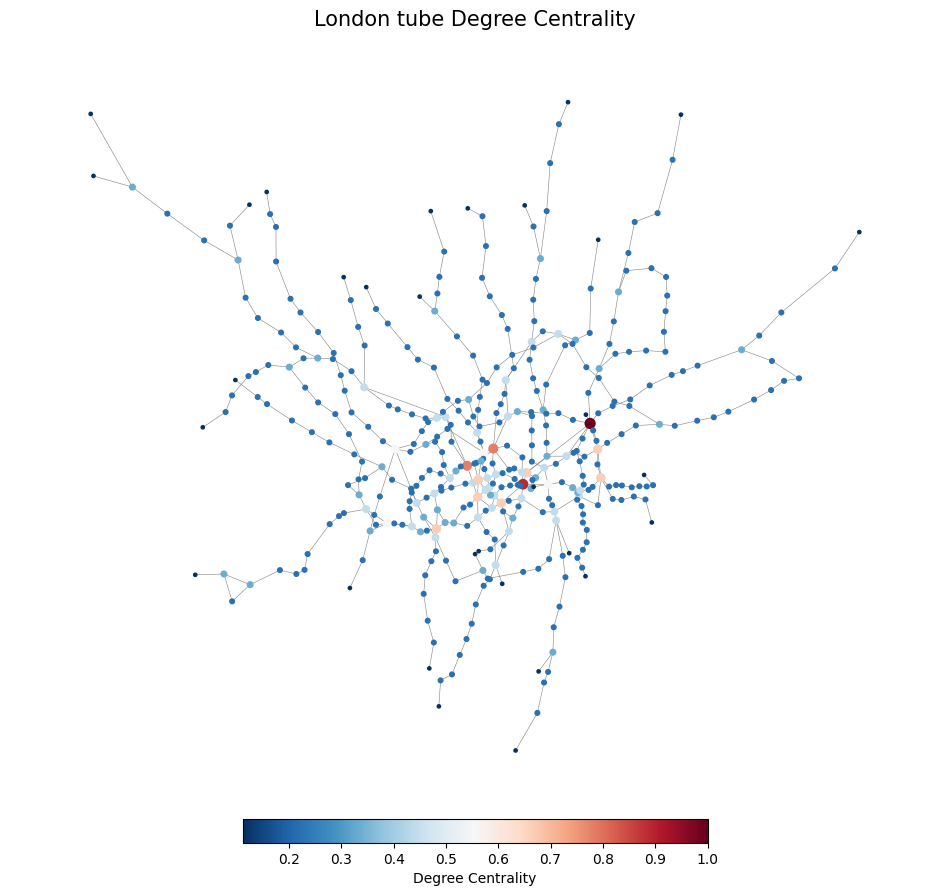

In [17]:
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]

deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]

# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size,
        cmap=cm.RdBu_r)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", pad=0.001, shrink=0.5)
plt.axis("off")
plt.title("London tube Degree Centrality",fontsize=15)
plt.show()

### 1.1.2 Topological betweenness centrality:

In [18]:
### Topological betweenness centrality:

#Let us compute the betweenness centrality for the network, without using weights:
T_betweenness_c=nx.betweenness_centrality(G, normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,T_betweenness_c,'betweenness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

df_T_betweenness_c = df.sort_values(["betweenness_t"], ascending=False)
df_T_betweenness_c = df_T_betweenness_c.reset_index(drop=True)
df_T_betweenness_c[0:10]

,station_name,betweenness_t
0,Stratford,23768.093434
1,Bank and Monument,23181.058947
2,Liverpool Street,21610.387049
3,King's Cross St. Pancras,20373.521465
4,Waterloo,19464.882323
5,Green Park,17223.622114
6,Euston,16624.275469
7,Westminster,16226.155916
8,Baker Street,15287.107612
9,Finchley Road,13173.758009


In [19]:
df_transposed_Tbc = df_T_betweenness_c[0:10].transpose()
df_transposed_Tbc

,0,1,2,3,4,5,6,7,8,9
station_name,Stratford,Bank and Monument,Liverpool Street,King's Cross St. Pancras,Waterloo,Green Park,Euston,Westminster,Baker Street,Finchley Road
betweenness_t,23768.093434,23181.058947,21610.387049,20373.521465,19464.882323,17223.622114,16624.275469,16226.155916,15287.107612,13173.758009


In [20]:
df_T_betweenness_c.shape

(401, 2)

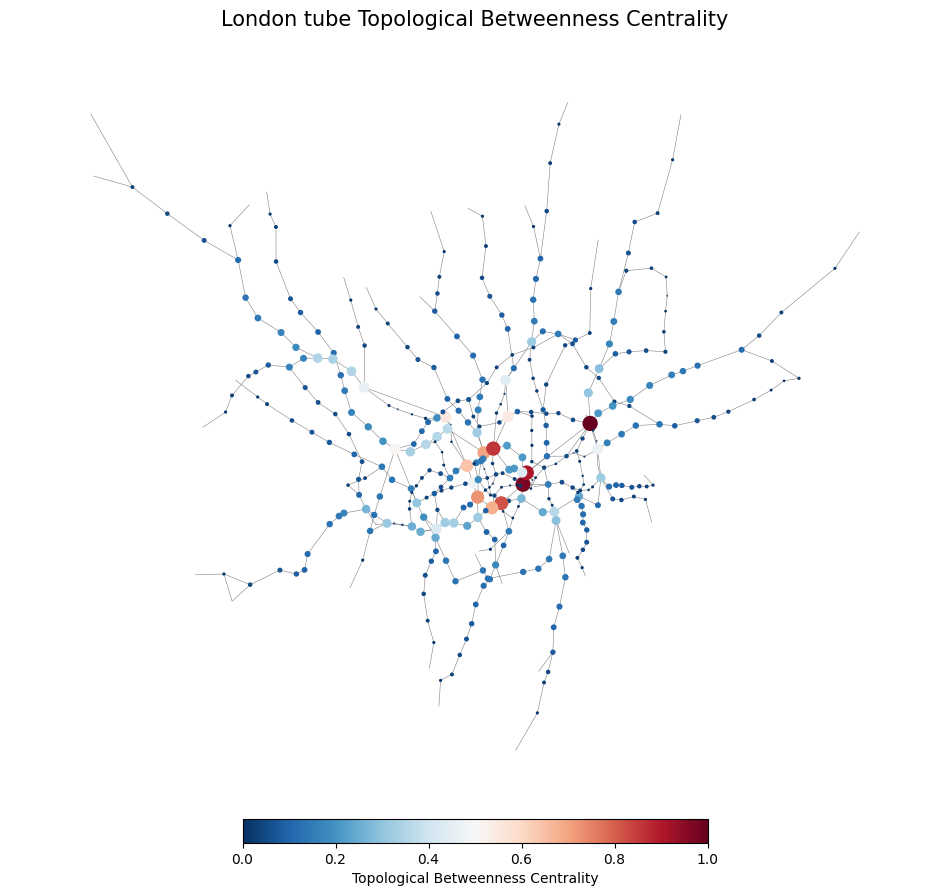

In [21]:
# Lets set colour and size of nodes according to betweenness values
betweenness_t_values=[(i[1]['betweenness_t']) for i in G.nodes(data=True)]

bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G.nodes(data=True)]
bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_t_color, node_size= bet_t_size, cmap=cm.RdBu_r)

plt.colorbar(nod,label="Topological Betweenness Centrality",orientation="horizontal", pad=0.001, shrink=0.5)
plt.axis("off")
plt.title("London tube Topological Betweenness Centrality",fontsize=15)
plt.show()

### 1.1.3 Topological Closeness Centrality

In [22]:
#topological closeness centrality
# 拓扑接近中心性
clos_t=nx.closeness_centrality(G)

# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))

df_T_closeness_c = df.sort_values(["closeness_t"], ascending=False)
df_T_closeness_c = df_T_closeness_c.reset_index(drop=True)
df_T_closeness_c[0:10]

,station_name,closeness_t
0,Green Park,0.114778
1,Bank and Monument,0.113572
2,King's Cross St. Pancras,0.113443
3,Westminster,0.112549
4,Waterloo,0.112265
5,Oxford Circus,0.111204
6,Bond Street,0.110988
7,Farringdon,0.110742
8,Angel,0.110742
9,Moorgate,0.110314


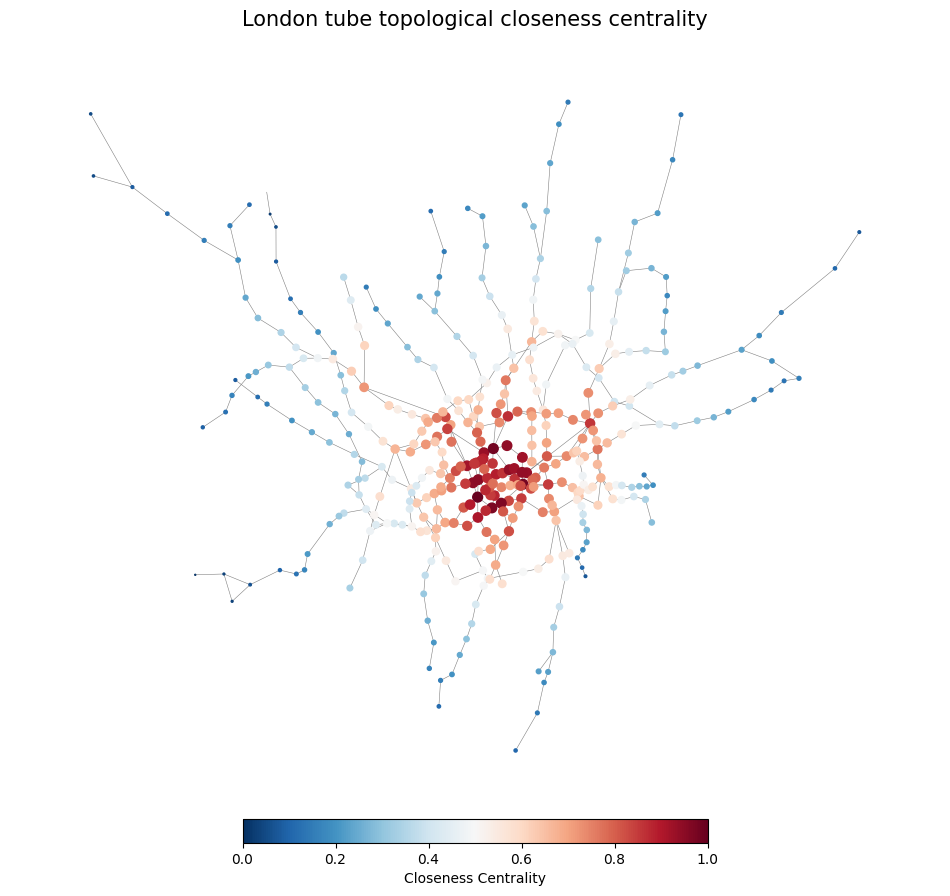

In [23]:
# Lets set color and width of nodes according to the closeness values
clos_t_val=[(i[1]['closeness_t']) for i in G.nodes(data=True)]

closs_t_color=[(i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val)) for i in G.nodes(data=True)]
closs_t_size=[((i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val))*50) for i in G.nodes(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= closs_t_color,
        node_size= closs_t_size, 
        cmap=cm.RdBu_r)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", pad=0.001, shrink=0.5)
plt.axis("off")
plt.title("London tube topological closeness centrality",fontsize=15)
plt.show()

## Part1 I.2 Impact measures:

Find 2 different measures to evaluate the impact of the node removal on the network. These need to be global measures referring to the whole network and not to specific nodes or links. Explain whether these two measures are specific to the London underground, or whether they could also be used to evaluate the resilience of any other network.

### 1.2.1 Average Path Length: 

**Average Path Length:**  The average of the shortest paths for all pairs of nodes.

### 1.2.2 Clustering coefficient:  <C>

### 1.2.3 Global efficiency

The global network efficiency is calculated based on the average of the path efficiencies between all pairs of nodes in the network. (Latora and Marchiori, 2001) The path efficiency is the reciprocal of the path length, and when all node pairs are considered, the global network efficiency reflects the strength of the average communication efficiency between any two nodes in the network.

### 1.2.4 Largest connected component (LCC)

Largest Connected Component (LCC) is that connected subgraph of a given graph (or network) that has the largest size. This component is the largest fully mutually reachable part of the entire network.

## Part1 I.3 Node removal:

For each of the centrality measures selected in I.1. remove at least 10 nodes following two different
strategies. 

A) Non-sequential removal: using the table created in I.1. remove 1 node at a time following the rank in the table, i.e. from the most important one to the 10th most important one. After each removal, evaluate the impact of the removal using your two measures in I.2. and proceed until you have removed at least 10 nodes. 

B) Sequential: remove the highest ranked node and evaluate the impact using the 2 measures. After removal, re-compute the centrality measure. Remove the highest ranked node in the new network and evaluate the impact. Continue until removing at least 10 nodes.

Report the results of the 2 strategies in one plot, and critically discuss the following: which centrality
measure reflects better the importance of a station for the functioning of the underground, which
strategy is more effective at studying resilience, and which impact measure is better at assessing the damage after node removal.

# 1.0 Betweenness

### Betweeness - Network_Efficiency - no Iteration - G1

In [24]:
df_T_betweenness_c

,station_name,betweenness_t
0,Stratford,23768.093434
1,Bank and Monument,23181.058947
2,Liverpool Street,21610.387049
3,King's Cross St. Pancras,20373.521465
4,Waterloo,19464.882323
...,...,...
396,Edgware,0.000000
397,Woolwich Arsenal,0.000000
398,Stratford International,0.000000
399,Watford Junction,0.000000


In [25]:
G1 = G.copy()

In [26]:
nx.average_shortest_path_length(G1)

13.545997506234414

In [27]:
df_T_betweenness_c_remove_G1 = df_T_betweenness_c[0:11]
df_T_betweenness_c_remove_G1

,station_name,betweenness_t
0,Stratford,23768.093434
1,Bank and Monument,23181.058947
2,Liverpool Street,21610.387049
3,King's Cross St. Pancras,20373.521465
4,Waterloo,19464.882323
5,Green Park,17223.622114
6,Euston,16624.275469
7,Westminster,16226.155916
8,Baker Street,15287.107612
9,Finchley Road,13173.758009


In [28]:
values_G1 = []

i = 0
while i < 11:
    E = nx.global_efficiency(G1)

    values_G1.append(E)  

    print(f'Network efficiency of G1 after {i} removals: {E}')
    G1.remove_node(df_T_betweenness_c_remove_G1.iloc[i]["station_name"])
    i += 1


Network efficiency of G1 after 0 removals: 0.1012561935972123
Network efficiency of G1 after 1 removals: 0.08891736066510689
Network efficiency of G1 after 2 removals: 0.08586164448742485
Network efficiency of G1 after 3 removals: 0.08496349266423939
Network efficiency of G1 after 4 removals: 0.07849775440713821
Network efficiency of G1 after 5 removals: 0.07594226578366223
Network efficiency of G1 after 6 removals: 0.07415154167648695
Network efficiency of G1 after 7 removals: 0.06820564659789057
Network efficiency of G1 after 8 removals: 0.06765950327361094
Network efficiency of G1 after 9 removals: 0.064700058053009
Network efficiency of G1 after 10 removals: 0.06313903700825897


### Betweeness - Network_Efficiency - Iteration - G2

In [29]:
G2 = G.copy()

In [30]:
nx.average_shortest_path_length(G2)

13.545997506234414

In [31]:
df_T_betweenness_c_G2 = df_T_betweenness_c.copy()
df_T_betweenness_c_G2

,station_name,betweenness_t
0,Stratford,23768.093434
1,Bank and Monument,23181.058947
2,Liverpool Street,21610.387049
3,King's Cross St. Pancras,20373.521465
4,Waterloo,19464.882323
...,...,...
396,Edgware,0.000000
397,Woolwich Arsenal,0.000000
398,Stratford International,0.000000
399,Watford Junction,0.000000


In [32]:
values_G2 = []

i = 0
while i < 11:  
    E = nx.global_efficiency(G2)

    values_G2.append(E)  

    print(f'Network efficiency of G2 after {i} removals: {E}')
    
    maxbet=[n for n in G2.nodes() if G2.nodes[n]['betweenness_t'] == max(betweenness_t_values)]

    G2.remove_node(df_T_betweenness_c_G2.iloc[0]["station_name"])

    bet_london_t=nx.betweenness_centrality(G2, normalized=False)

    # We can add these values to the nodes attributes:
    nx.set_node_attributes(G2,bet_london_t,'betweenness_t')

    # To ataframe using the nodes as the index
    df = pd.DataFrame(index=G2.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(G2, 'station_name'))
    df['betweenness_t'] = pd.Series(nx.get_node_attributes(G2, 'betweenness_t'))

    df_T_betweenness_c_G2 = df.sort_values(["betweenness_t"], ascending=False)
    df_T_betweenness_c_G2 = df_T_betweenness_c_G2.reset_index(drop=True)
    
    i += 1  


Network efficiency of G2 after 0 removals: 0.1012561935972123
Network efficiency of G2 after 1 removals: 0.08891736066510689
Network efficiency of G2 after 2 removals: 0.08460293133575152
Network efficiency of G2 after 3 removals: 0.08182895253292936
Network efficiency of G2 after 4 removals: 0.07767794342812263
Network efficiency of G2 after 5 removals: 0.07283234083472483
Network efficiency of G2 after 6 removals: 0.053210203984026455
Network efficiency of G2 after 7 removals: 0.05165629952389727
Network efficiency of G2 after 8 removals: 0.0458442134055722
Network efficiency of G2 after 9 removals: 0.04163076968121037


Network efficiency of G2 after 10 removals: 0.0381637040943985


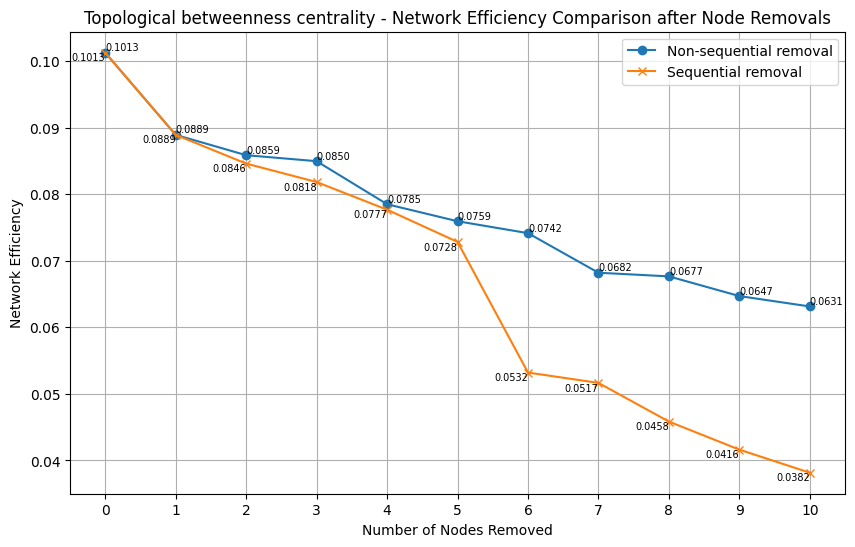

In [33]:
import matplotlib.pyplot as plt

removals = list(range(11))

plt.figure(figsize=(10, 6))
plt.plot(removals, values_G1, label='Non-sequential removal', marker='o')
plt.plot(removals, values_G2, label='Sequential removal', marker='x')

plt.title('Topological betweenness centrality - Network Efficiency Comparison after Node Removals')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Network Efficiency')
plt.legend(loc='upper right')

plt.xticks(removals)
plt.grid(axis='x')

for i in range(len(removals)):
    plt.text(removals[i], values_G1[i], f'{values_G1[i]:.4f}', ha='left', va='bottom', fontsize=7)
    plt.text(removals[i], values_G2[i], f'{values_G2[i]:.4f}', ha='right', va='top', fontsize=7)

plt.grid(True)
plt.show()


### Betweeness - LCC - no Iteration - G3

In [34]:
G3 = G.copy()

In [35]:
nx.connected_components(G3)

<generator object connected_components at 0x000001F66A9D7B50>

In [36]:
df_T_betweenness_c_remove_G3 = df_T_betweenness_c[0:11]
df_T_betweenness_c_remove_G3

,station_name,betweenness_t
0,Stratford,23768.093434
1,Bank and Monument,23181.058947
2,Liverpool Street,21610.387049
3,King's Cross St. Pancras,20373.521465
4,Waterloo,19464.882323
5,Green Park,17223.622114
6,Euston,16624.275469
7,Westminster,16226.155916
8,Baker Street,15287.107612
9,Finchley Road,13173.758009


In [37]:
import networkx as nx

def largest_connected_component_size(G):
    if nx.is_empty(G):
        return 0
    largest_cc = max(nx.connected_components(G), key=len)
    return len(largest_cc)

largest_connected_component_size(G3)


401

In [38]:
values_G3 = []

i = 0
while i < 11:  
    L = largest_connected_component_size(G3)

    values_G3.append(L) 

    print(f'Largest Connected Component of G3 after {i} removals: {L}')

    G3.remove_node(df_T_betweenness_c_remove_G3.iloc[i]["station_name"])
    
    i += 1


Largest Connected Component of G3 after 0 removals: 401
Largest Connected Component of G3 after 1 removals: 379
Largest Connected Component of G3 after 2 removals: 378
Largest Connected Component of G3 after 3 removals: 377
Largest Connected Component of G3 after 4 removals: 371
Largest Connected Component of G3 after 5 removals: 370
Largest Connected Component of G3 after 6 removals: 369
Largest Connected Component of G3 after 7 removals: 346
Largest Connected Component of G3 after 8 removals: 345
Largest Connected Component of G3 after 9 removals: 342
Largest Connected Component of G3 after 10 removals: 339


### Betweeness - LCC - Iteration - G4

In [39]:
G4 = G.copy()

In [40]:
nx.connected_components(G4)

<generator object connected_components at 0x000001F66A9D6D40>

In [41]:
df_T_betweenness_c_G4 = df_T_betweenness_c.copy()
df_T_betweenness_c_G4

,station_name,betweenness_t
0,Stratford,23768.093434
1,Bank and Monument,23181.058947
2,Liverpool Street,21610.387049
3,King's Cross St. Pancras,20373.521465
4,Waterloo,19464.882323
...,...,...
396,Edgware,0.000000
397,Woolwich Arsenal,0.000000
398,Stratford International,0.000000
399,Watford Junction,0.000000


In [42]:
values_G4 = []


i = 0
while i < 11:  
    L = largest_connected_component_size(G4)

    values_G4.append(L) 

    print(f'Largest Connected Component of G4 after {i} removals: {L}')
    
    maxbet=[n for n in G4.nodes() if G4.nodes[n]['betweenness_t'] == max(betweenness_t_values)]

    G4.remove_node(df_T_betweenness_c_G4.iloc[0]["station_name"])

    bet_london_t=nx.betweenness_centrality(G4, normalized=False)

    # We can add these values to the nodes attributes:
    nx.set_node_attributes(G4,bet_london_t,'betweenness_t')

    # To ataframe using the nodes as the index
    df = pd.DataFrame(index=G4.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(G4, 'station_name'))
    df['betweenness_t'] = pd.Series(nx.get_node_attributes(G4, 'betweenness_t'))

    df_T_betweenness_c_G4 = df.sort_values(["betweenness_t"], ascending=False)
    df_T_betweenness_c_G4 = df_T_betweenness_c_G4.reset_index(drop=True)
    
    i += 1  


Largest Connected Component of G4 after 0 removals: 401
Largest Connected Component of G4 after 1 removals: 379
Largest Connected Component of G4 after 2 removals: 378
Largest Connected Component of G4 after 3 removals: 377
Largest Connected Component of G4 after 4 removals: 376


Largest Connected Component of G4 after 5 removals: 375
Largest Connected Component of G4 after 6 removals: 227
Largest Connected Component of G4 after 7 removals: 226
Largest Connected Component of G4 after 8 removals: 196
Largest Connected Component of G4 after 9 removals: 173
Largest Connected Component of G4 after 10 removals: 170


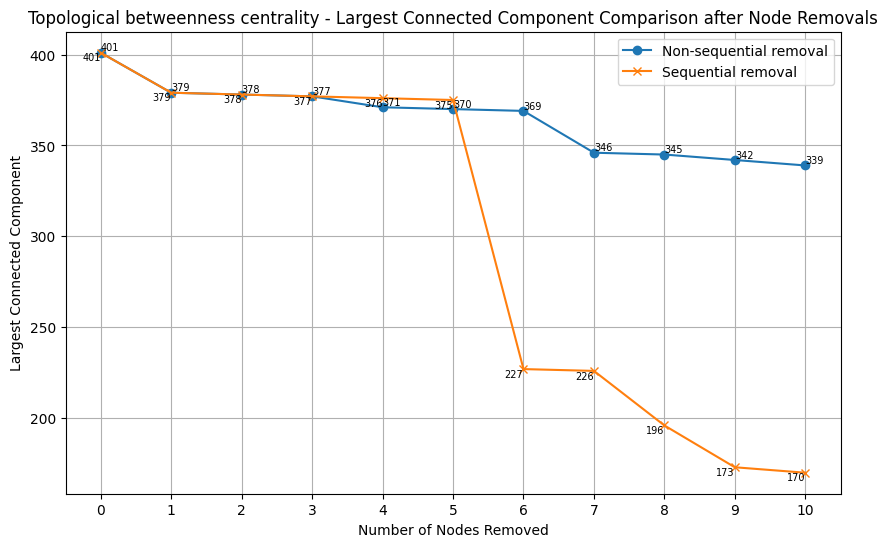

In [43]:
import matplotlib.pyplot as plt

removals = list(range(11))

plt.figure(figsize=(10, 6))
plt.plot(removals, values_G3, label='Non-sequential removal', marker='o')
plt.plot(removals, values_G4, label='Sequential removal', marker='x')

plt.title('Topological betweenness centrality - Largest Connected Component Comparison after Node Removals')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Largest Connected Component')
plt.legend(loc='upper right')

plt.xticks(removals)
plt.grid(axis='x')

for i in range(len(removals)):
    plt.text(removals[i], values_G3[i], f'{values_G3[i]:}', ha='left', va='bottom', fontsize=7)
    plt.text(removals[i], values_G4[i], f'{values_G4[i]:}', ha='right', va='top', fontsize=7)

plt.grid(True)
plt.show()


# 2.0 Closeness

### Closeness - Network_Efficiency - no Iteration - G5

In [44]:
df_T_closeness_c

,station_name,closeness_t
0,Green Park,0.114778
1,Bank and Monument,0.113572
2,King's Cross St. Pancras,0.113443
3,Westminster,0.112549
4,Waterloo,0.112265
...,...,...
396,Heathrow Terminals 2 & 3,0.045096
397,Heathrow Terminal 4,0.045091
398,Watford High Street,0.044302
399,Heathrow Terminal 5,0.043155


In [45]:
G5 = G.copy()

In [46]:
df_T_closeness_c_remove_G5 = df_T_closeness_c[0:11]
df_T_closeness_c_remove_G5

,station_name,closeness_t
0,Green Park,0.114778
1,Bank and Monument,0.113572
2,King's Cross St. Pancras,0.113443
3,Westminster,0.112549
4,Waterloo,0.112265
5,Oxford Circus,0.111204
6,Bond Street,0.110988
7,Farringdon,0.110742
8,Angel,0.110742
9,Moorgate,0.110314


In [47]:
values_G5 = []

i = 0
while i < 11:  
    E = nx.global_efficiency(G5)

    values_G5.append(E)  

    print(f'Network efficiency of G5 after {i} removals: {E}')
    
    G5.remove_node(df_T_closeness_c_remove_G5.iloc[i]["station_name"])
    
    i += 1  

Network efficiency of G5 after 0 removals: 0.1012561935972123
Network efficiency of G5 after 1 removals: 0.09918991960788402
Network efficiency of G5 after 2 removals: 0.09487232544791133
Network efficiency of G5 after 3 removals: 0.08793385149140875
Network efficiency of G5 after 4 removals: 0.08737164566976727
Network efficiency of G5 after 5 removals: 0.08485943799789313
Network efficiency of G5 after 6 removals: 0.08278135073141742
Network efficiency of G5 after 7 removals: 0.08258086417012774
Network efficiency of G5 after 8 removals: 0.08260040537396239
Network efficiency of G5 after 9 removals: 0.08262233108950982
Network efficiency of G5 after 10 removals: 0.08166991436767818


### Closeness - Network_Efficiency - Iteration - G6

In [48]:
G6 = G.copy()

In [49]:
df_T_closeness_c_G6 = df_T_closeness_c.copy()
df_T_closeness_c_G6

,station_name,closeness_t
0,Green Park,0.114778
1,Bank and Monument,0.113572
2,King's Cross St. Pancras,0.113443
3,Westminster,0.112549
4,Waterloo,0.112265
...,...,...
396,Heathrow Terminals 2 & 3,0.045096
397,Heathrow Terminal 4,0.045091
398,Watford High Street,0.044302
399,Heathrow Terminal 5,0.043155


In [50]:
closeness_t_values=[(i[1]['closeness_t']) for i in G.nodes(data=True)]


In [51]:
values_G6 = []

for i in range(11):  
    E = nx.global_efficiency(G6)

    values_G6.append(E) 

    print(f'Network efficiency of G6 after {i} removals: {E}')
    
    max_closeness_node = max(G6.nodes(data="closeness_t"), key=lambda x: x[1])
  
    if G6.has_node(max_closeness_node[0]):
        G6.remove_node(max_closeness_node[0])
    else:
        print(f"Node {max_closeness_node[0]} not found in G6.")
        break
    
    clos_london_t = nx.closeness_centrality(G6)
    nx.set_node_attributes(G6, clos_london_t, 'closeness_t')


Network efficiency of G6 after 0 removals: 0.1012561935972123


Network efficiency of G6 after 1 removals: 0.09918991960788402
Network efficiency of G6 after 2 removals: 0.09443475025566316
Network efficiency of G6 after 3 removals: 0.09181648060183005
Network efficiency of G6 after 4 removals: 0.08542563066911478
Network efficiency of G6 after 5 removals: 0.08054424756502003
Network efficiency of G6 after 6 removals: 0.05810104159173278
Network efficiency of G6 after 7 removals: 0.051883620553389555
Network efficiency of G6 after 8 removals: 0.05035000093626794
Network efficiency of G6 after 9 removals: 0.04439458727102797
Network efficiency of G6 after 10 removals: 0.04295771061337044


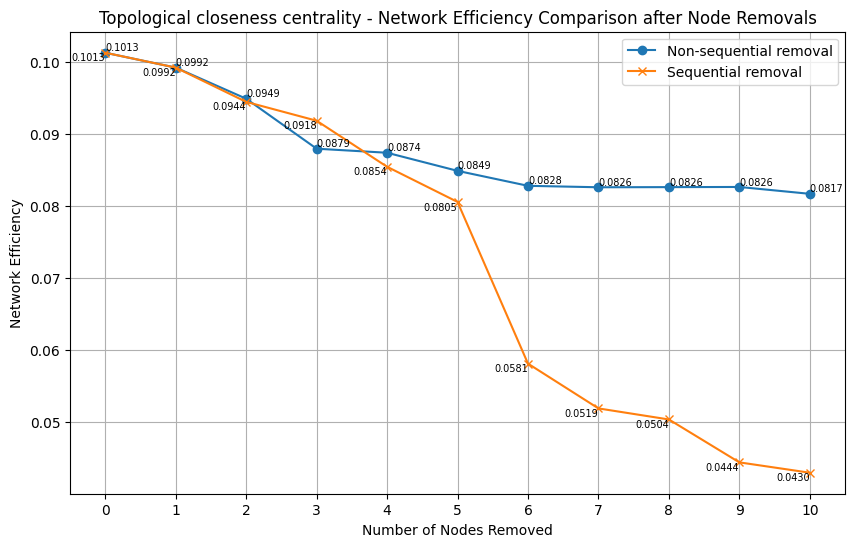

In [52]:
import matplotlib.pyplot as plt

removals = list(range(11))

plt.figure(figsize=(10, 6))
plt.plot(removals, values_G5, label='Non-sequential removal', marker='o')
plt.plot(removals, values_G6, label='Sequential removal', marker='x')

plt.title('Topological closeness centrality - Network Efficiency Comparison after Node Removals')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Network Efficiency')
plt.legend(loc='upper right')

plt.xticks(removals)
plt.grid(axis='x')

for i in range(len(removals)):
    plt.text(removals[i], values_G5[i], f'{values_G5[i]:.4f}', ha='left', va='bottom', fontsize=7)
    plt.text(removals[i], values_G6[i], f'{values_G6[i]:.4f}', ha='right', va='top', fontsize=7)

plt.grid(True)
plt.show()

### Closeness - LCC - no Iteration -G7

In [53]:
G7 = G.copy()

In [54]:
nx.connected_components(G7)

<generator object connected_components at 0x000001F66A9D7D30>

In [55]:
df_T_closeness_c_remove_G7 = df_T_closeness_c[0:11]
df_T_closeness_c_remove_G7

,station_name,closeness_t
0,Green Park,0.114778
1,Bank and Monument,0.113572
2,King's Cross St. Pancras,0.113443
3,Westminster,0.112549
4,Waterloo,0.112265
5,Oxford Circus,0.111204
6,Bond Street,0.110988
7,Farringdon,0.110742
8,Angel,0.110742
9,Moorgate,0.110314


In [56]:
import networkx as nx

def largest_connected_component_size(G):
    if nx.is_empty(G):
        return 0
    largest_cc = max(nx.connected_components(G), key=len)
    return len(largest_cc)

largest_connected_component_size(G7)


401

In [57]:
values_G7 = []

i = 0
while i < 11:  
    L = largest_connected_component_size(G7)

    values_G7.append(L)

    print(f'Largest Connected Component of G7 after {i} removals: {L}')

    G7.remove_node(df_T_closeness_c_remove_G7.iloc[i]["station_name"])
    
    i += 1 

Largest Connected Component of G7 after 0 removals: 401
Largest Connected Component of G7 after 1 removals: 400
Largest Connected Component of G7 after 2 removals: 399
Largest Connected Component of G7 after 3 removals: 398
Largest Connected Component of G7 after 4 removals: 397
Largest Connected Component of G7 after 5 removals: 396
Largest Connected Component of G7 after 6 removals: 395
Largest Connected Component of G7 after 7 removals: 394
Largest Connected Component of G7 after 8 removals: 393
Largest Connected Component of G7 after 9 removals: 392
Largest Connected Component of G7 after 10 removals: 389


### Closeness - LCC - Iteration -G8

In [58]:
G8 = G.copy()

In [59]:
nx.connected_components(G8)

<generator object connected_components at 0x000001F66A9D7970>

In [60]:
df_T_closeness_c_G8 = df_T_closeness_c.copy()
df_T_closeness_c_G8

,station_name,closeness_t
0,Green Park,0.114778
1,Bank and Monument,0.113572
2,King's Cross St. Pancras,0.113443
3,Westminster,0.112549
4,Waterloo,0.112265
...,...,...
396,Heathrow Terminals 2 & 3,0.045096
397,Heathrow Terminal 4,0.045091
398,Watford High Street,0.044302
399,Heathrow Terminal 5,0.043155


In [61]:
values_G8 = []

for i in range(11): 
    L = largest_connected_component_size(G8)

    values_G8.append(L)

    print(f'Largest Connected Component of G8 after {i} removals: {L}')
    
    max_closeness_node = max(G8.nodes(data="closeness_t"), key=lambda x: x[1])
    
    if G8.has_node(max_closeness_node[0]):
        G8.remove_node(max_closeness_node[0])
    else:
        print(f"Node {max_closeness_node[0]} not found in G8.")
        break
    
    # closeness centrality
    clos_london_t = nx.closeness_centrality(G8)
    nx.set_node_attributes(G8, clos_london_t, 'closeness_t')


Largest Connected Component of G8 after 0 removals: 401
Largest Connected Component of G8 after 1 removals: 400
Largest Connected Component of G8 after 2 removals: 399
Largest Connected Component of G8 after 3 removals: 398
Largest Connected Component of G8 after 4 removals: 397
Largest Connected Component of G8 after 5 removals: 396
Largest Connected Component of G8 after 6 removals: 226
Largest Connected Component of G8 after 7 removals: 226
Largest Connected Component of G8 after 8 removals: 225
Largest Connected Component of G8 after 9 removals: 195
Largest Connected Component of G8 after 10 removals: 194


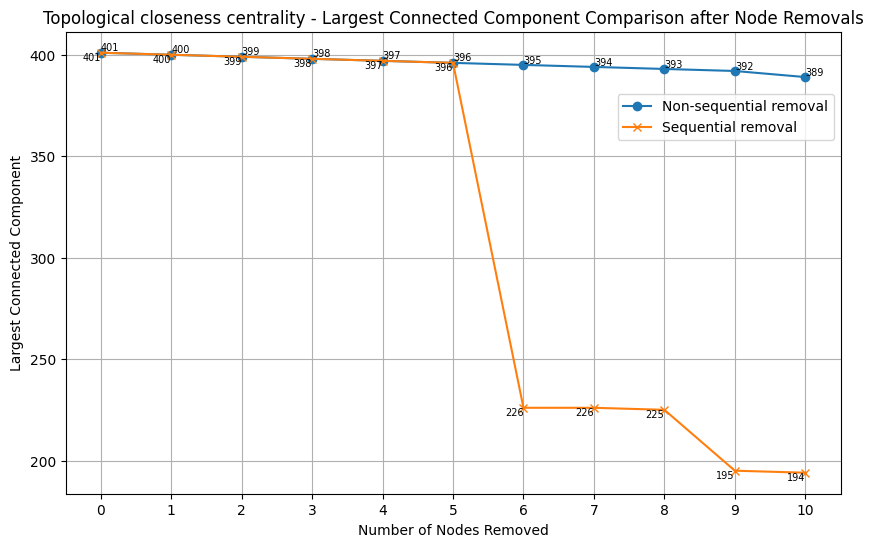

In [62]:
import matplotlib.pyplot as plt

removals = list(range(11))

plt.figure(figsize=(10, 6))
plt.plot(removals, values_G7, label='Non-sequential removal', marker='o')
plt.plot(removals, values_G8, label='Sequential removal', marker='x')

plt.title('Topological closeness centrality - Largest Connected Component Comparison after Node Removals')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Largest Connected Component')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.88))

plt.xticks(removals)
plt.grid(axis='x')

for i in range(len(removals)):
    plt.text(removals[i], values_G7[i], f'{values_G7[i]:}', ha='left', va='bottom', fontsize=7)
    plt.text(removals[i], values_G8[i], f'{values_G8[i]:}', ha='right', va='top', fontsize=7)

plt.grid(True)
plt.show()


### Degree - Network_Efficiency - no Iteration - G9

In [63]:
G9 = G.copy()

In [64]:
#  We can calculate the degree centrality using networkx function:
degree_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(degree_london),'degree')

In [65]:
df_degree_c_G9 = df_degree_c[0:11]
df_degree_c_G9 

,station_name,degree
0,Stratford,0.0225
1,Bank and Monument,0.0200
2,King's Cross St. Pancras,0.0175
3,Baker Street,0.0175
4,Earl's Court,0.0150
5,Oxford Circus,0.0150
6,Liverpool Street,0.0150
7,Waterloo,0.0150
8,Green Park,0.0150
9,Canning Town,0.0150


In [66]:
values_G9 = []

i = 0
while i < 11:  
    E = nx.global_efficiency(G9)

    values_G9.append(E)

    print(f'Network efficiency of G9 after {i} removals: {E}')
    
    G9.remove_node(df_degree_c_G9 .iloc[i]["station_name"])
    
    i += 1  

Network efficiency of G9 after 0 removals: 0.1012561935972123
Network efficiency of G9 after 1 removals: 0.08891736066510689
Network efficiency of G9 after 2 removals: 0.08586164448742485
Network efficiency of G9 after 3 removals: 0.08028700838265396
Network efficiency of G9 after 4 removals: 0.07570039409751211


Network efficiency of G9 after 5 removals: 0.0740361229198828
Network efficiency of G9 after 6 removals: 0.07274535237569829
Network efficiency of G9 after 7 removals: 0.07094844226118287
Network efficiency of G9 after 8 removals: 0.06898194318071488
Network efficiency of G9 after 9 removals: 0.06825731584971681
Network efficiency of G9 after 10 removals: 0.06338447666647608


### Degree - Network_Efficiency - Iteration - G10

In [67]:
G10 = G.copy()

In [68]:
df_degree_c_G10 = df_degree_c.copy()
df_degree_c_G10

,station_name,degree
0,Stratford,0.0225
1,Bank and Monument,0.0200
2,King's Cross St. Pancras,0.0175
3,Baker Street,0.0175
4,Earl's Court,0.0150
...,...,...
396,High Barnet,0.0025
397,Battersea Park,0.0025
398,New Cross,0.0025
399,Crystal Palace,0.0025


In [69]:
values_G10 = []

i = 0
while i < 11:  
    E = nx.global_efficiency(G10)

    values_G10.append(E)

    print(f'Network efficiency of G10 after {i} removals: {E}')

    degree_c = nx.degree_centrality(G10)

    # We can add these values to the nodes attributes:
    nx.set_node_attributes(G10,degree_c,'degree_c')

    degree_values=[(i[1]['degree']) for i in G10.nodes(data=True)]
    
    maxbet=[n for n in G10.nodes() if G10.nodes[n]['degree_c'] == max(degree_values)]

    G10.remove_node(df_degree_c_G10.iloc[0]["station_name"])

    # To ataframe using the nodes as the index
    df = pd.DataFrame(index=G10.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(G10, 'station_name'))
    df['degree_c'] = pd.Series(nx.get_node_attributes(G10, 'degree_c'))

    df_degree_c_G10 = df.sort_values(["degree_c"], ascending=False)
    df_degree_c_G10 = df_degree_c_G10.reset_index(drop=True)
    
    i += 1 


Network efficiency of G10 after 0 removals: 0.1012561935972123
Network efficiency of G10 after 1 removals: 0.08891736066510689
Network efficiency of G10 after 2 removals: 0.08586164448742485
Network efficiency of G10 after 3 removals: 0.08028700838265396
Network efficiency of G10 after 4 removals: 0.07570039409751211
Network efficiency of G10 after 5 removals: 0.0740361229198828
Network efficiency of G10 after 6 removals: 0.07300367580539921
Network efficiency of G10 after 7 removals: 0.07187870616238219
Network efficiency of G10 after 8 removals: 0.0666869485473866
Network efficiency of G10 after 9 removals: 0.05885009150648866
Network efficiency of G10 after 10 removals: 0.056747518813518014


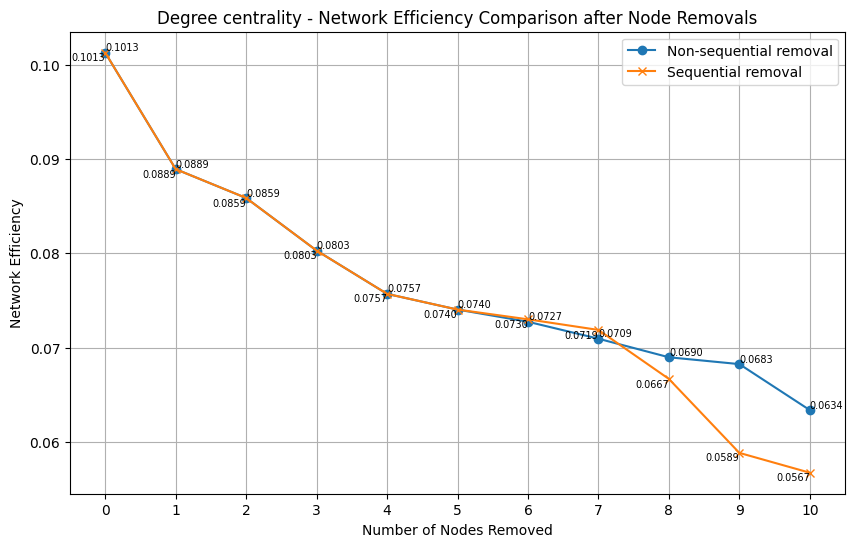

In [70]:
import matplotlib.pyplot as plt

removals = list(range(11))

plt.figure(figsize=(10, 6))
plt.plot(removals, values_G9, label='Non-sequential removal', marker='o')
plt.plot(removals, values_G10, label='Sequential removal', marker='x')

plt.title('Degree centrality - Network Efficiency Comparison after Node Removals')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Network Efficiency')
plt.legend(loc='upper right')

plt.xticks(removals)
plt.grid(axis='x')

for i in range(len(removals)):
    plt.text(removals[i], values_G9[i], f'{values_G9[i]:.4f}', ha='left', va='bottom', fontsize=7)
    plt.text(removals[i], values_G10[i], f'{values_G10[i]:.4f}', ha='right', va='top', fontsize=7)

plt.grid(True)
plt.show()

### Degree - LCC - no Iteration -G11

In [71]:
G11 = G.copy()

In [72]:
df_degree_c_G11 = df_degree_c.copy()
df_degree_c_G11

,station_name,degree
0,Stratford,0.0225
1,Bank and Monument,0.0200
2,King's Cross St. Pancras,0.0175
3,Baker Street,0.0175
4,Earl's Court,0.0150
...,...,...
396,High Barnet,0.0025
397,Battersea Park,0.0025
398,New Cross,0.0025
399,Crystal Palace,0.0025


In [73]:
import networkx as nx

def largest_connected_component_size(G):
    if nx.is_empty(G):
        return 0
    largest_cc = max(nx.connected_components(G), key=len)
    return len(largest_cc)

largest_connected_component_size(G11)


401

In [74]:
values_G11 = []

i = 0
while i < 11:  
    L = largest_connected_component_size(G11)

    values_G11.append(L) 

    print(f'Largest Connected Component of G11 after {i} removals: {L}')
    
    G11.remove_node(df_degree_c_G11.iloc[i]["station_name"])
    
    i += 1  

Largest Connected Component of G11 after 0 removals: 401
Largest Connected Component of G11 after 1 removals: 379
Largest Connected Component of G11 after 2 removals: 378
Largest Connected Component of G11 after 3 removals: 377
Largest Connected Component of G11 after 4 removals: 374
Largest Connected Component of G11 after 5 removals: 373
Largest Connected Component of G11 after 6 removals: 371
Largest Connected Component of G11 after 7 removals: 365
Largest Connected Component of G11 after 8 removals: 364
Largest Connected Component of G11 after 9 removals: 363
Largest Connected Component of G11 after 10 removals: 349


### Degree - LCC - Iteration -G12

In [75]:
G12 = G.copy()

In [76]:
df_degree_c_G12 = df_degree_c.copy()
df_degree_c_G12

,station_name,degree
0,Stratford,0.0225
1,Bank and Monument,0.0200
2,King's Cross St. Pancras,0.0175
3,Baker Street,0.0175
4,Earl's Court,0.0150
...,...,...
396,High Barnet,0.0025
397,Battersea Park,0.0025
398,New Cross,0.0025
399,Crystal Palace,0.0025


In [77]:
values_G12 = []

for i in range(11): 
    L = largest_connected_component_size(G12)

    values_G12.append(L) 

    print(f'Largest Connected Component of G12 after {i} removals: {L}')

    degree_c_london = nx.degree_centrality(G12)
    nx.set_node_attributes(G12, degree_c_london, 'degree_c')
  
    max_degree_node = max(G12.nodes(data="degree_c"), key=lambda x: x[1])
    
    if G12.has_node(max_degree_node[0]):
        G12.remove_node(max_degree_node[0])
    else:
        print(f"Node {max_degree_node[0]} not found in G12.")
        break
    
    # closeness centrality
    degree_c_london = nx.degree_centrality(G12)
    nx.set_node_attributes(G12, degree_c_london, 'degree_c')


Largest Connected Component of G12 after 0 removals: 401
Largest Connected Component of G12 after 1 removals: 379
Largest Connected Component of G12 after 2 removals: 378
Largest Connected Component of G12 after 3 removals: 377
Largest Connected Component of G12 after 4 removals: 374
Largest Connected Component of G12 after 5 removals: 360
Largest Connected Component of G12 after 6 removals: 359
Largest Connected Component of G12 after 7 removals: 358
Largest Connected Component of G12 after 8 removals: 357
Largest Connected Component of G12 after 9 removals: 355
Largest Connected Component of G12 after 10 removals: 341


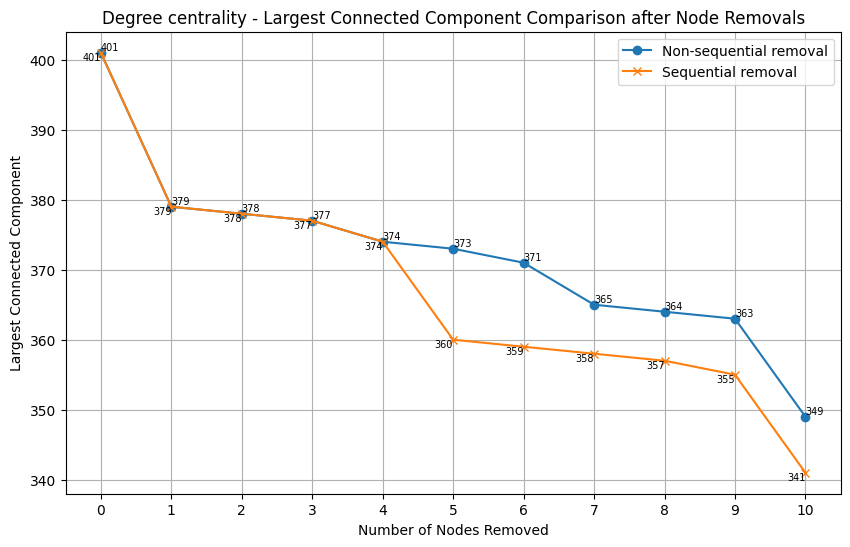

In [78]:
import matplotlib.pyplot as plt

removals = list(range(11))

plt.figure(figsize=(10, 6))
plt.plot(removals, values_G11, label='Non-sequential removal', marker='o')
plt.plot(removals, values_G12, label='Sequential removal', marker='x')

plt.title('Degree centrality - Largest Connected Component Comparison after Node Removals')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Largest Connected Component')
plt.legend(loc='upper right')

plt.xticks(removals)
plt.grid(axis='x')

for i in range(len(removals)):
    plt.text(removals[i], values_G11[i], f'{values_G11[i]:}', ha='left', va='bottom', fontsize=7)
    plt.text(removals[i], values_G12[i], f'{values_G12[i]:}', ha='right', va='top', fontsize=7)

plt.grid(True)
plt.show()


# Part1 II. Flows: weighted network

In this section, you will include passengers into the underground, and assess whether different measures need to be used when flows are considered. The network to use in this section is the weighted network given to you in the coursework, where the flows of passengers were assigned to the links between stations.

In [79]:
df_G

,source,target,length,flows,line_name
0,Wembley Park,Kingsbury,2916.771558,12356,Jubilee
1,Wembley Park,Neasden,2353.165938,6744,Jubilee
2,Wembley Park,Preston Road,1419.735166,36601,Metropolitan
3,Wembley Park,Finchley Road,7266.373927,55216,Metropolitan
4,Kingsbury,Queensbury,1245.995234,9419,Jubilee
...,...,...,...,...,...
462,Hounslow Central,Hounslow East,745.684383,13469,Piccadilly
463,Hounslow East,Osterley,967.494672,15935,Piccadilly
464,Osterley,Boston Manor,2560.814291,17445,Piccadilly
465,Boston Manor,Northfields,930.852145,18598,Piccadilly


In [80]:
df_G_flows = df_G.sort_values(["flows"], ascending=False)
df_G_flows[0:20]

,source,target,length,flows,line_name
38,Waterloo,Westminster,850.360026,219499,Jubilee
42,Waterloo,Bank and Monument,2542.954444,216157,Waterloo & City
43,Westminster,Green Park,1423.780195,189976,Jubilee
103,Bank and Monument,Liverpool Street,841.502684,160401,Central
14,Stratford,Liverpool Street,6698.461270,146148,TfL Rail
46,Green Park,Bond Street,1148.912313,140801,Jubilee
232,Euston,King's Cross St. Pancras,863.369674,132144,Victoria
50,Green Park,Oxford Circus,1010.566475,125407,Victoria
49,Green Park,Victoria,1209.599809,121521,Victoria
196,Highbury & Islington,King's Cross St. Pancras,2581.853010,120037,Victoria


# II.1 

 Consider the centrality measure derived in I. indicating the most relevant stations for assessing the vulnerability of the underground. What would you need to do to adjust this measure for a weighted network? Recompute the ranking of the 10 most important nodes according to this adjusted measure. Do you find the same ones as in I.1?

Based on the "Topological network": The station most associated with tube network vulnerability based on "degree centrality" and "topological betweenness centrality" is Stratford. The station most associated with tube network vulnerability based on "topological closeness centrality" is Green Park.

In the previous section “Topological network”, we concluded that betweenness centrality better reflects the importance of stations for underground operations. Therefore, we will use this centrality in this section.

In the previous section, we used topological betweenness centrality. In the use of weighted networks, elements such as traffic, distance, etc., are considered as weights, hence the use of weighted betweenness centrality as a centrality measure.

## II.1.1 Weighted betweenness centrality: weighted-flows

In [81]:
### Weighted betweenness centrality:
# 加权中心度：

#Let us compute the betweenness centrality for the network, considering the distance between stations:

# W_betweenness_c = nx.betweenness_centrality(G,weight='flows',normalized=False)
W_betweenness_c = nx.betweenness_centrality(G, weight=lambda u, v, d: 1 / d['flows'] if d['flows'] > 0 else float('inf'), normalized=False)

# We can add these values to the nodes attributes:

nx.set_node_attributes(G,W_betweenness_c,'betweenness_w')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['betweenness_w'] = pd.Series(nx.get_node_attributes(G, 'betweenness_w'))

df_W_betweenness_c = df.sort_values(["betweenness_w"], ascending=False)
df_W_betweenness_c = df_W_betweenness_c.reset_index(drop=True)
df_W_betweenness_c[0:10]

,station_name,betweenness_w
0,Green Park,45311.620345
1,Bank and Monument,40317.741212
2,Waterloo,32720.649912
3,Westminster,30080.962295
4,Stratford,27759.262142
5,Liverpool Street,26848.579108
6,Bond Street,23188.980459
7,Euston,22600.517152
8,Oxford Circus,21453.463388
9,Warren Street,20140.612103


In [82]:
df_W_betweenness_c.shape

(401, 2)

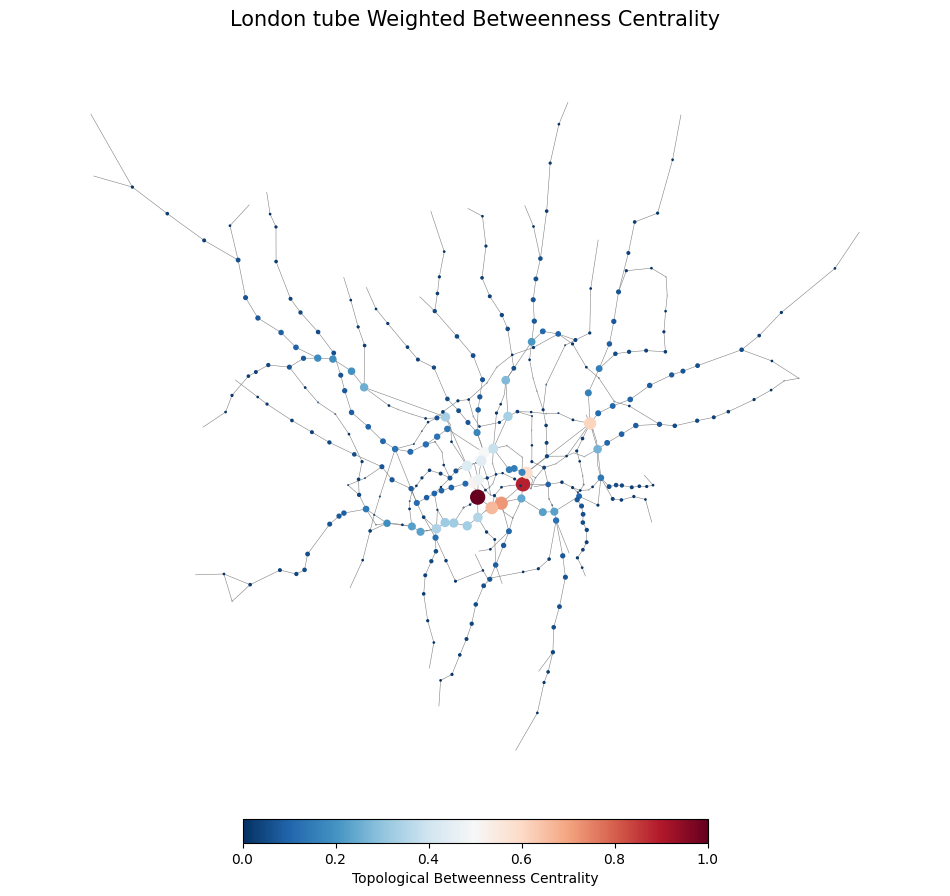

In [83]:
# Lets set colour and size of nodes according to betweenness values

betweenness_w_values=[(i[1]['betweenness_w']) for i in G.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) for i in G.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values))*100 for i in G.nodes(data=True)]

# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size, 
        cmap=cm.RdBu_r)

plt.colorbar(nod,label="Topological Betweenness Centrality",orientation="horizontal", pad=0.001, shrink=0.5)
plt.axis("off")
plt.title("London tube Weighted Betweenness Centrality",fontsize=15)
plt.show()

# II.2

II.2. Now consider the measure for assessing the impact of node removal. Would you adjust the measure for a weighted network? If yes, how? Propose a different measure that would be better at assessing the impact of closing a station taking into consideration the passengers.

Considering the impact of weighted networks, we should adjust the measures for assessing the impact of node removal. The definition and calculation of the LCC show that its value is independent of whether the network is weighted or not. Therefore, it doesn't have to be changed. 

To improve global efficiency, we use “weighted network efficiency”. Weighted network efficiency considers the weights of paths rather than simply counting the number of paths. In such a network, when calculating the shortest path, the aim is to minimize the total weights rather than the path lengths.


### weighted network efficiency

In [84]:
G_w_effi = G.copy()

In [85]:
df_W_betweenness_c_G_w_effi = df_W_betweenness_c.copy()
df_W_betweenness_c_G_w_effi

,station_name,betweenness_w
0,Green Park,45311.620345
1,Bank and Monument,40317.741212
2,Waterloo,32720.649912
3,Westminster,30080.962295
4,Stratford,27759.262142
...,...,...
396,West Croydon,0.000000
397,Shenfield,0.000000
398,Marylebone,0.000000
399,Regent's Park,0.000000


In [88]:
import networkx as nx

def weighted_network_efficiency(G, weight='weight'):
    n = len(G)
    if n < 2:
        return 0  

    sum_of_inverses = 0.0
    for node in G:
        length = nx.single_source_dijkstra_path_length(G, node, weight=weight)
        sum_of_inverses += sum(1 / dist if dist != 0 else 0 for dist in length.values())

    return sum_of_inverses / (n * (n - 1))

efficiency = weighted_network_efficiency(G_w_effi, weight=lambda u, v, d: 1 / d['flows'] if d['flows'] > 0 else float('inf'))
print("Weighted Network Efficiency:", efficiency)


Weighted Network Efficiency: 2648.7211556005577


In [89]:
i = 0
while i < 10:  
    efficiency = weighted_network_efficiency(G_w_effi, weight=lambda u, v, d: 1 / d['flows'] if d['flows'] > 0 else float('inf'))
    print('Network efficiency of G2:', efficiency)
    
    maxbet=[n for n in G_w_effi.nodes() if G_w_effi.nodes[n]['betweenness_t'] == max(betweenness_t_values)]

    G_w_effi.remove_node(df_W_betweenness_c_G_w_effi.iloc[0]["station_name"])

    bet_london_t=nx.betweenness_centrality(G_w_effi, normalized=False)

    # We can add these values to the nodes attributes:
    nx.set_node_attributes(G_w_effi,bet_london_t,'betweenness_t')

    # To ataframe using the nodes as the index
    df = pd.DataFrame(index=G_w_effi.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(G_w_effi, 'station_name'))
    df['betweenness_t'] = pd.Series(nx.get_node_attributes(G_w_effi, 'betweenness_t'))

    df_W_betweenness_c_G_w_effi = df.sort_values(["betweenness_t"], ascending=False)
    df_W_betweenness_c_G_w_effi = df_W_betweenness_c_G_w_effi.reset_index(drop=True)
    
    i += 1 


Network efficiency of G2: 2648.7211556005577
Network efficiency of G2: 2387.1023224681153
Network efficiency of G2: 2014.7955326612696
Network efficiency of G2: 1699.7976780319566
Network efficiency of G2: 1316.121974477409
Network efficiency of G2: 1063.8715668803038
Network efficiency of G2: 907.8040659648551
Network efficiency of G2: 822.3192182782865
Network efficiency of G2: 709.7836336193228
Network efficiency of G2: 605.1821018211851


# II.3

II.3. Remove only the 3 highest ranked nodes according to the best performing centrality measure found in I.1. Evaluate the impact according to the 2 measures in II.2. Repeat the experiment for the
highest 3 ranked nodes using the adjusted measure. Critically discuss which station closure will have the largest impact on passengers, referring to your measures and results.

In [90]:
df_Wbc_G23_1 = df_W_betweenness_c.copy()
df_Wbc_G23_1

,station_name,betweenness_w
0,Green Park,45311.620345
1,Bank and Monument,40317.741212
2,Waterloo,32720.649912
3,Westminster,30080.962295
4,Stratford,27759.262142
...,...,...
396,West Croydon,0.000000
397,Shenfield,0.000000
398,Marylebone,0.000000
399,Regent's Park,0.000000


The best performing centrality measure: weighted betweenness centrality

Two impact measures: “weighted network efficiency” and “LCC”

Two strategies: non-sequential removal and sequential removal

In these two plots, three stations of non-sequential removal are: Green Park, Bank and Monument, Waterloo; three stations of sequential removal are: Green Park, Stratford, Euston.


### Weighted_Efficiency - no Iteration

In [91]:
df_Wbc_G23_1 = df_W_betweenness_c.copy()
df_Wbc_G23_1

,station_name,betweenness_w
0,Green Park,45311.620345
1,Bank and Monument,40317.741212
2,Waterloo,32720.649912
3,Westminster,30080.962295
4,Stratford,27759.262142
...,...,...
396,West Croydon,0.000000
397,Shenfield,0.000000
398,Marylebone,0.000000
399,Regent's Park,0.000000


In [92]:
G23_1 = G.copy()

In [93]:
values_G23_1 = []

i = 0
while i < 4:
    E = weighted_network_efficiency(G23_1, weight=lambda u, v, d: 1 / d['flows'] if d['flows'] > 0 else float('inf'))

    values_G23_1.append(E)  

    print(f'Network efficiency of G23_1 after {i} removals: {E}; Station name is {df_Wbc_G23_1.iloc[i]["station_name"]}')
    G23_1.remove_node(df_Wbc_G23_1.iloc[i]["station_name"])
    i += 1


Network efficiency of G23_1 after 0 removals: 2648.7211556005577; Station name is Green Park
Network efficiency of G23_1 after 1 removals: 2387.1023224681153; Station name is Bank and Monument


Network efficiency of G23_1 after 2 removals: 2062.540984157389; Station name is Waterloo
Network efficiency of G23_1 after 3 removals: 1970.7790696629625; Station name is Westminster


### Weighted Efficiency - Iteration

In [94]:
df_Wbc_G23_2 = df_W_betweenness_c.copy()
df_Wbc_G23_2

,station_name,betweenness_w
0,Green Park,45311.620345
1,Bank and Monument,40317.741212
2,Waterloo,32720.649912
3,Westminster,30080.962295
4,Stratford,27759.262142
...,...,...
396,West Croydon,0.000000
397,Shenfield,0.000000
398,Marylebone,0.000000
399,Regent's Park,0.000000


In [95]:
G23_2 = G.copy()

In [96]:
values_G23_2 = []

i = 0
while i < 4:  
    E = weighted_network_efficiency(G23_2, weight=lambda u, v, d: 1 / d['flows'] if d['flows'] > 0 else float('inf'))

    values_G23_2.append(E)  

    print(f'Network efficiency of G23_2 after {i} removals: {E}; Station name is {df_Wbc_G23_2.iloc[i]["station_name"]}')
    
    maxbet=[n for n in G23_2.nodes() if G23_2.nodes[n]['betweenness_w'] == max(betweenness_w_values)]

    G23_2.remove_node(df_Wbc_G23_2.iloc[i]["station_name"])

    bet_london_w=nx.betweenness_centrality(G23_2, normalized=False)

    # We can add these values to the nodes attributes:
    nx.set_node_attributes(G23_2,bet_london_w,'betweenness_w')

    # To ataframe using the nodes as the index
    df = pd.DataFrame(index=G23_2.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(G23_2, 'station_name'))
    df['betweenness_w'] = pd.Series(nx.get_node_attributes(G23_2, 'betweenness_w'))

    df_Wbc_G23_2 = df.sort_values(["betweenness_w"], ascending=False)
    df_Wbc_G23_2 = df_Wbc_G23_2.reset_index(drop=True)
    df_Wbc_G23_2
    
    i += 1 


Network efficiency of G23_2 after 0 removals: 2648.7211556005577; Station name is Green Park
Network efficiency of G23_2 after 1 removals: 2387.1023224681153; Station name is Stratford
Network efficiency of G23_2 after 2 removals: 1987.3751524364313; Station name is Euston
Network efficiency of G23_2 after 3 removals: 1703.5522957041758; Station name is Finchley Road


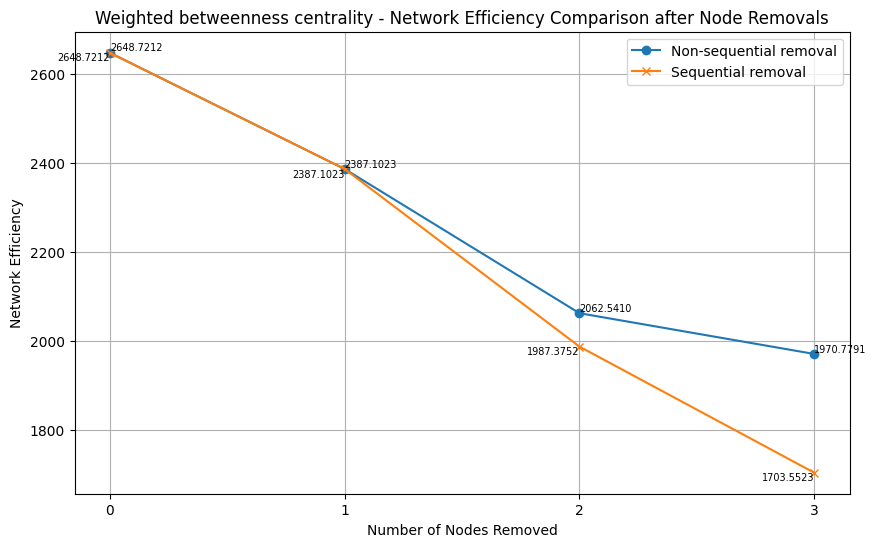

In [97]:
import matplotlib.pyplot as plt

removals = list(range(4))

plt.figure(figsize=(10, 6))
plt.plot(removals, values_G23_1, label='Non-sequential removal', marker='o')
plt.plot(removals, values_G23_2, label='Sequential removal', marker='x')

plt.title('Weighted betweenness centrality - Network Efficiency Comparison after Node Removals')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Network Efficiency')
plt.legend(loc='upper right')

plt.xticks(removals)
plt.grid(axis='x')

for i in range(len(removals)):
    plt.text(removals[i], values_G23_1[i], f'{values_G23_1[i]:.4f}', ha='left', va='bottom', fontsize=7)
    plt.text(removals[i], values_G23_2[i], f'{values_G23_2[i]:.4f}', ha='right', va='top', fontsize=7)

plt.grid(True)
plt.show()

### LCC - no Iteration

In [98]:
df_Wbc_G23_3 = df_W_betweenness_c.copy()
df_Wbc_G23_3

,station_name,betweenness_w
0,Green Park,45311.620345
1,Bank and Monument,40317.741212
2,Waterloo,32720.649912
3,Westminster,30080.962295
4,Stratford,27759.262142
...,...,...
396,West Croydon,0.000000
397,Shenfield,0.000000
398,Marylebone,0.000000
399,Regent's Park,0.000000


In [99]:
G23_3 = G.copy()

In [100]:
import networkx as nx

def largest_connected_component_size(G):
    if nx.is_empty(G):
        return 0
    largest_cc = max(nx.connected_components(G), key=len)
    return len(largest_cc)

largest_connected_component_size(G23_3)


401

In [101]:
values_G23_3 = []

i = 0
while i < 4:
    L = largest_connected_component_size(G23_3)

    values_G23_3.append(L)  

    print(f'LCC of G23_3 after {i} removals: {L}; Station name is {df_Wbc_G23_3.iloc[i]["station_name"]}')
    G23_3.remove_node(df_Wbc_G23_1.iloc[i]["station_name"])
    i += 1


LCC of G23_3 after 0 removals: 401; Station name is Green Park
LCC of G23_3 after 1 removals: 400; Station name is Bank and Monument
LCC of G23_3 after 2 removals: 399; Station name is Waterloo
LCC of G23_3 after 3 removals: 398; Station name is Westminster


### LCC - Iteration

In [102]:
df_Wbc_G23_4 = df_W_betweenness_c.copy()
df_Wbc_G23_4

,station_name,betweenness_w
0,Green Park,45311.620345
1,Bank and Monument,40317.741212
2,Waterloo,32720.649912
3,Westminster,30080.962295
4,Stratford,27759.262142
...,...,...
396,West Croydon,0.000000
397,Shenfield,0.000000
398,Marylebone,0.000000
399,Regent's Park,0.000000


In [103]:
G23_4 = G.copy()

In [104]:
import networkx as nx

def largest_connected_component_size(G):
    if nx.is_empty(G):
        return 0
    largest_cc = max(nx.connected_components(G), key=len)
    return len(largest_cc)

largest_connected_component_size(G23_4)



401

In [105]:
values_G23_4 = []


i = 0
while i < 4:  
    L = largest_connected_component_size(G23_4)

    values_G23_4.append(L) 

    print(f'Largest Connected Component of G4 after {i} removals: {L}; Station name is {df_Wbc_G23_4.iloc[i]["station_name"]}')
   
    maxbet=[n for n in G23_4.nodes() if G23_4.nodes[n]['betweenness_w'] == max(betweenness_w_values)]

    G23_4.remove_node(df_Wbc_G23_4.iloc[i]["station_name"])

    bet_london_w=nx.betweenness_centrality(G23_4)

    # We can add these values to the nodes attributes:
    nx.set_node_attributes(G23_4,bet_london_w,'betweenness_w')

    # To ataframe using the nodes as the index
    df = pd.DataFrame(index=G23_4.nodes())
    df['station_name'] = pd.Series(nx.get_node_attributes(G23_4, 'station_name'))
    df['betweenness_w'] = pd.Series(nx.get_node_attributes(G23_4, 'betweenness_w'))

    df_Wbc_G23_4 = df.sort_values(["betweenness_w"], ascending=False)
    df_Wbc_G23_4 = df_Wbc_G23_4.reset_index(drop=True)
    
    i += 1  


Largest Connected Component of G4 after 0 removals: 401; Station name is Green Park
Largest Connected Component of G4 after 1 removals: 400; Station name is Stratford
Largest Connected Component of G4 after 2 removals: 378; Station name is Euston


Largest Connected Component of G4 after 3 removals: 355; Station name is Finchley Road


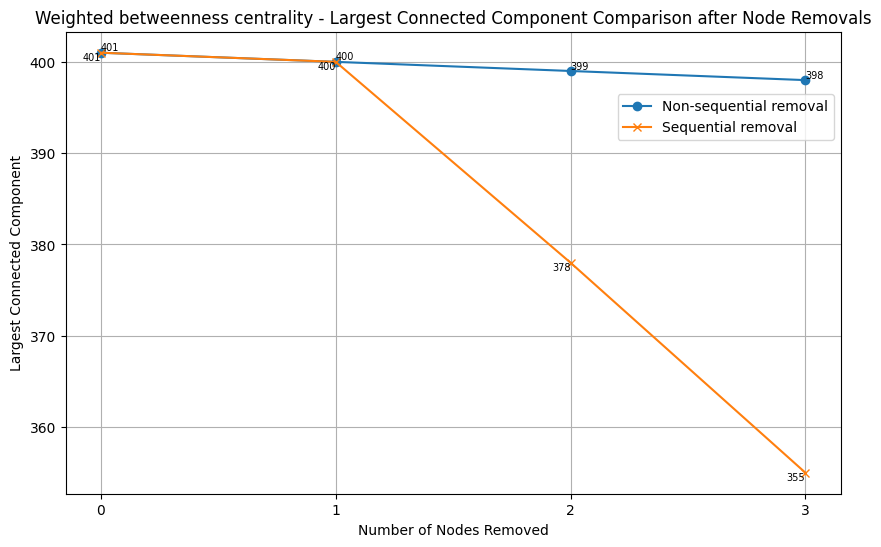

In [106]:
import matplotlib.pyplot as plt

removals = list(range(4))

plt.figure(figsize=(10, 6))
plt.plot(removals, values_G23_3, label='Non-sequential removal', marker='o')
plt.plot(removals, values_G23_4, label='Sequential removal', marker='x')

plt.title('Weighted betweenness centrality - Largest Connected Component Comparison after Node Removals')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Largest Connected Component')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.88))

plt.xticks(removals)
plt.grid(axis='x')

for i in range(len(removals)):
    plt.text(removals[i], values_G23_3[i], f'{values_G23_3[i]:}', ha='left', va='bottom', fontsize=7)
    plt.text(removals[i], values_G23_4[i], f'{values_G23_4[i]:}', ha='right', va='top', fontsize=7)

plt.grid(True)
plt.show()